In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Read in Data and Models

In [2]:
# read in saved data
train_dset = tf.data.experimental.load('../data/dsets/train_dset-128',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))
val_dset = tf.data.experimental.load('../data/dsets/val_dset-128',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))
test_dset = tf.data.experimental.load('../data/dsets/test_dset-128',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))

In [3]:
y_test = np.concatenate([y for x, y in test_dset], axis=0) # one-hot representation

In [4]:
# TODO run with final models
# read in saved models
model_cnn = tf.keras.models.load_model("trained-models/model_cnn")
model_lstm = tf.keras.models.load_model("../models/model-0005-128-300-128-0.8-l2reg")

# Run Predictions on Test Set

In [5]:
y_pred_cnn = model_cnn.predict(test_dset)
y_pred_lstm = model_lstm.predict(test_dset)

# Binarize Problem

In [6]:
# class of interest
focusClass = 'good'

In [7]:
name_to_label = {
    'bad_inner_thigh': 0,
    'bad_back_round': 1,
    'bad_back_warp': 2,
    'bad_head': 3,
    'bad_shallow': 4,
    'bad_toe': 5,
    'good': 6
}

focusLabel = name_to_label[focusClass]

In [8]:
# binarize problem
prob_pred_cnn = y_pred_cnn[:,focusLabel]
prob_pred_lstm = y_pred_lstm[:,focusLabel]
y_test = y_test[:,focusLabel]

# Generate ROC Curves

In [9]:
def choose_operating_point(fpr, tpr, thresholds):
    # choose operating point based on Youden's index
    sensitivities = tpr
    specificities = 1-fpr
    
    J = sensitivities + specificities - 1
    
    idx = np.argmax(J)
    
    fpr = fpr[idx]
    tpr = tpr[idx]
    
    return fpr, tpr

In [10]:
fpr_cnn, tpr_cnn, thresh_cnn = roc_curve(y_test, prob_pred_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)
fpr_cnn_opt, tpr_cnn_opt = choose_operating_point(fpr_cnn,tpr_cnn,thresh_cnn)

fpr_lstm, tpr_lstm, thresh_lstm = roc_curve(y_test, prob_pred_lstm)
auc_lstm = auc(fpr_lstm, tpr_lstm)
fpr_lstm_opt, tpr_lstm_opt = choose_operating_point(fpr_lstm,tpr_lstm,thresh_lstm)

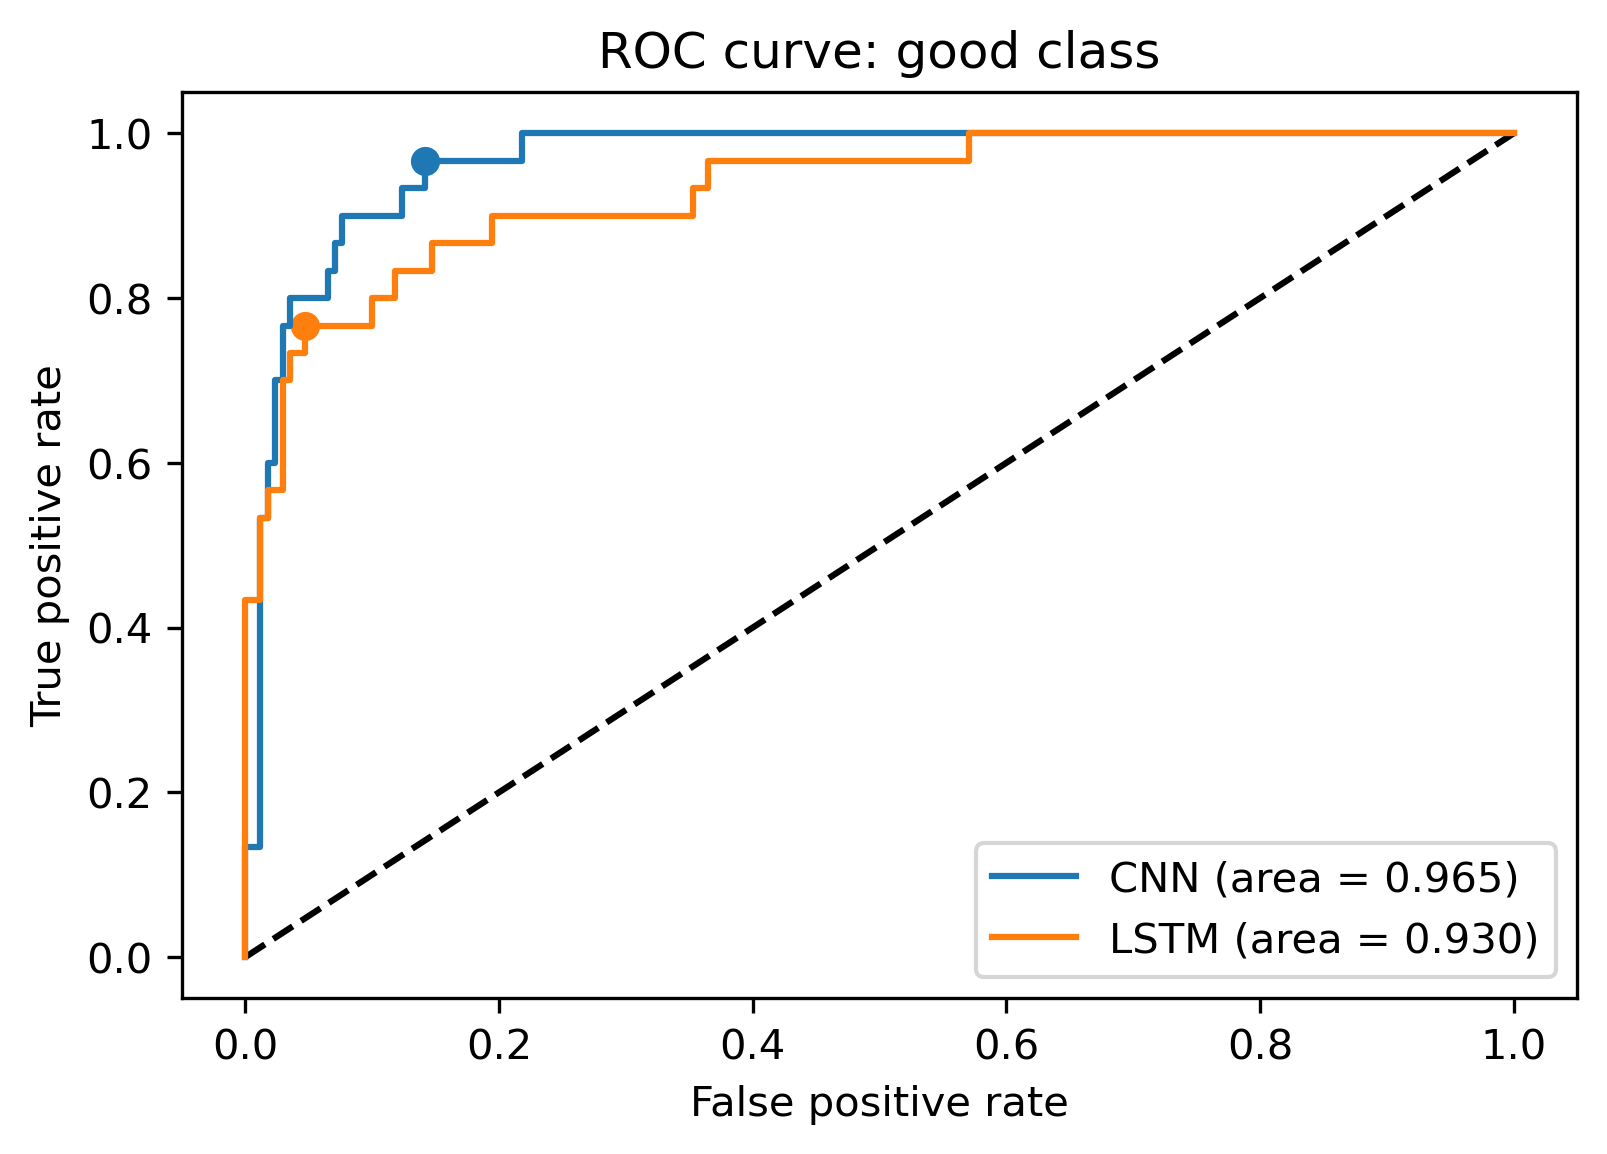

CNN operating point sensitivity: 0.967
CNN operating point specificity: 0.859

LSTM operating point sensitivity: 0.767
LSTM operating point specificity: 0.953


In [11]:
# plot ROC curves with selected operating points
plt.figure(dpi=300)
plt.plot([0, 1], [0, 1], 'k--') # random guess
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.scatter(fpr_cnn_opt,tpr_cnn_opt)
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (area = {:.3f})'.format(auc_lstm))
plt.scatter(fpr_lstm_opt,tpr_lstm_opt)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: %s class' %focusClass)
plt.legend(loc='best')
plt.show()

# report operating point info
print('CNN operating point sensitivity: %.3f' %tpr_cnn_opt)
print('CNN operating point specificity: %.3f\n' %(1-fpr_cnn_opt))
print('LSTM operating point sensitivity: %.3f' %tpr_lstm_opt)
print('LSTM operating point specificity: %.3f' %(1-fpr_lstm_opt))